# <font size="70"><span style="color:#545C94"> Detección de tumores cerebrales</span></font>

### Visión Artificial y Reconocimiento de patrones

### Curso académico 2022-2023

### Autores:
- Pablo Palacios López
- Juan Ramón Romero García
- Jaime Parada López

# 1. Importamos librerias

In [1]:
!pip install plot-keras-history
!pip install split-folders

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9474 sha256=cc0acecf4487b5fe29e971af72b1b28bc1a073451addc9822086878c1b8ed0cd
  Stored in directory: /root/.cache/pip/wheels/f1/91/1c/bdba9dfd430fdabe38c1077da71de189658be21716be91d184
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320514 sha256=692e885b92dfeb1b36fa7abffd2285fe42fa280367968ac2001357c197c2776c
  Stored in directory: /root/.cache/pip/wheels/df/61/fa/0598614d92032edbee232e8a1ee86bba214cc4392a10f11e7e
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5651 sha256=abac6ee410252fcfe0120d3b218e4631d5851cc1f3cfb46600e2093bd5bb7f55
  St

In [2]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import warnings
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

import splitfolders

from collections import defaultdict

from plot_keras_history import plot_history

# 2. Importamos la base de datos

Almacenaremos las rutas de las carpetas de la base de datos, en dos variables `train_dir` y `test_dir`.

In [3]:
train_dir = r'../input/brain-tumor-mri-dataset/Training'
test_dir = '../input/brain-tumor-mri-dataset/Testing'

Hemos podido observas cómo en algunas otras libretas con bases de datos parecidas, muchos usuarios tienden a utilizar el conjunto de prueba como conjunto de validación, nosotros no cometeremos este error y dividiremos el conjunto de datos de entrenamiento en train y validación, dándole un 80% al train y un 20% a la validación.

In [4]:
splitfolders.ratio(train_dir, output="output", ratio=(0.8,0.2))
warnings.filterwarnings("ignore")

Copying files: 5712 files [00:51, 110.65 files/s]


In [5]:
train_dir = '/kaggle/working/output/train'
val_dir = '/kaggle/working/output/val'

En la variable`train_paths` almacenamos la dirección de cada imagen, mientras que en la variable `train_labels` la categoría a la que pertenece cada imagen.

In [6]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

En la variable`val_paths` almacenamos la dirección de cada imagen, mientras que en la variable `val_labels` la categoría a la que pertenece cada imagen.

In [7]:
val_paths = []
val_labels = []

for label in os.listdir(val_dir):
    for image in os.listdir(val_dir+"//" +label):
        val_paths.append(val_dir + '//'+label+ '//'+image)
        val_labels.append(label)

val_paths, val_labels = shuffle(val_paths, val_labels)

En la variable`test_paths` almacenamos la dirección de cada imagen, mientras que en la variable `test_labels` la categoría a la que pertenece cada imagen.

In [8]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Como podemos observar el conjunto de datos de entrenamiento tendrá un tamaño de 65%, el conjunto de datos de validación tendrá un 16% y el test de un 19%.

In [9]:
print("Tamaño del train: " + str(round(100*(len(train_paths)/(len(train_paths)+len(val_paths)+len(test_paths))))) + " %")
print("Tamaño del validación: " + str(round(100*(len(val_paths)/(len(train_paths)+len(val_paths)+len(test_paths))))) + " %")
print("Tamaño del test: " + str(round(100*(len(test_paths)/(len(train_paths)+len(val_paths)+len(test_paths))))) + " %")

Tamaño del train: 65 %
Tamaño del validación: 16 %
Tamaño del test: 19 %


# 3. Analisis exploratorio de datos

Nuestra base de datos se dividirá en 4 tipos:
- noTumor: imágenes que no ocntienen ningún tumor.
- meningioma: imágenes de tumores que se originan en el cerebro o la médula espinal.
- glioma: imágenes de tumores que nacen de las células de soporte del tejido cerebral. 
- pituitary: imágenes de tumores que presentan crecimientos anormales en la glándula pituitaria. 

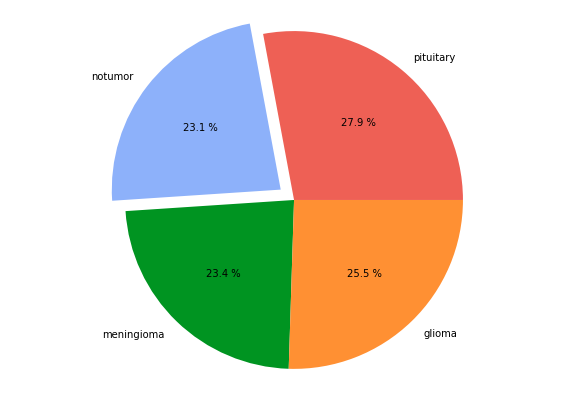

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
numImagenes = [len(os.listdir(train_dir+"//" +label)) for label in os.listdir(train_dir)] 
nombres = ["pituitary","notumor","meningioma","glioma"]
colores = ["#EE6055","#8DB1FA","#009421","#FF9033"]
desfase = (0, 0.1, 0, 0)
plt.pie(numImagenes, labels=nombres, autopct="%0.1f %%", colors=colores, explode=desfase)
plt.axis("equal")
plt.show()

Observamos una muestra, mediante una función que nos mostrará las imágenes del conjunto de datos.

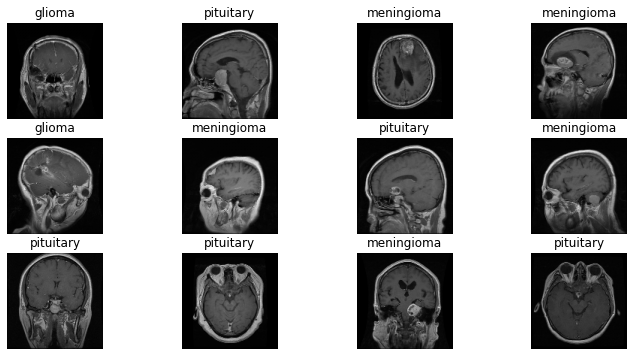

In [11]:
# La función verImagen será un método al que llamaremos y nos mostrará las imágenes que le pasemos en función
# del rango de fotos que le pasemos por parámetros. Dentro de la función va leyendo en un bucle cada foto y la va
# concatenando en un array, para retornarlas todas juntas.

def verImagen(rutas):
    imagenes = []
    for ruta in rutas:
        imagen = load_img(ruta, target_size=(128, 128))
        imagen = np.array(imagen)/255.0
        imagenes.append(imagen)
    return np.array(imagenes)

# Llamamos a la función previamente realizada y le pasamos por parámetros el rango de foto que queremos mostrar.

imagenes = verImagen(train_paths[50:63])
labels = train_labels[50:63]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 13):
    fig.add_subplot(3, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(imagenes[x])
plt.show()

# 4. Creación de modelos

Vamos a realizar 3 modelos para compararlos entre ellos, aplicando diferentes técnicas a la hora de crear las capas de las redes convolucionales o a la hora de aplicar diferentes técnicas de aumento de datos etc.

* El primer modelo consistirá en una red neuronal convolucional donde aplicaremos las técnicas de aumento de datos y regularización, para añadir más imágenes mediante técnicas como randomZoom, randomRotation o randomFlip, y además incluiremos la una capa de dropout, la cual consistirá en poner a 0 algunas de sus salidas al azar, con una probabilidad. Con las técnicas citadas previamente podremos evitar el sobreajuste y obtener un mejor modelo.

* El segundo modelo consistirá en una red neuronal convolucional donde no añadiremos ninguna técnica para evitar el sobreajuste, como pudiera ser el aumento de datos o regularización de los mismos. Con este modelo podremos observar cómo sin las técnicas que se han descrito anteriormente, el modelo tiende a sobreajustar.

* El tercer modelo consistirá en la realización de la técnica conocida como transfer learning, la cual consiste en crear redes neuronales convolucionales y entrenarlas desde cero con modelos ya entrenados con grandes conjuntos de datos. Lo que se hace para tratar problemas mediante transfer learning es mantener los parámetros de la red neuronal convolucional original y añadir capas completamente conectadas, después del vector de características profundas, para que estas se centren en aprender los parámetros de acuerdo con el problema a resolver.


In [12]:
models = defaultdict(None)

# 4.1 Modelo 1

## Capas de la red convolucional

Vamos a diseñar una red neuronal convolución con las siguientes capas.

In [13]:
model = Sequential()

# Capa de red convolucional.
model.add(Conv2D(32,(3,3), input_shape=(200, 200, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de aplanamiento, una capa completamente conectada y la capa de salida.
model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

2023-01-07 23:54:26.210688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 23:54:26.211627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 23:54:26.432568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 23:54:26.433410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 23:54:26.434132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Añadimos el modelo al diccionario de modelos.

In [14]:
models['Modelo1'] = model

Configuramos el modelo para el entrenamiento.

In [15]:
models['Modelo1'].compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
warnings.filterwarnings("ignore")

## Preparación de los datos

Generamos el conjunto de entrenamiento aplicandole los valores correspondientes que ayudarán a que no sobreajuste el modelo, y a su vez, generamos el conjunto de validación y de prueba.

In [16]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0.1,
                                    zoom_range = 0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)
generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

train = generator_train.flow_from_directory('/kaggle/working/output/train', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')
val = generator_test.flow_from_directory('/kaggle/working/output/val', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')
test = generator_test.flow_from_directory('../input/brain-tumor-mri-dataset/Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')


Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Creación del callback

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]

# 4.2 Modelo 2

## Capas de la red convolucional

Vamos a diseñar una red neuronal convolución con las siguientes capas.

In [18]:
model = Sequential()

# Capa de red convolucional.
model.add(Conv2D(32,(3,3), input_shape=(200, 200, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de red convolucional.
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa de aplanamiento, una capa completamente conectada y la capa de salida.
model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
warnings.filterwarnings("ignore")

Añadimos el modelo al diccionario de modelos.

In [19]:
models['Modelo2'] = model

Configuramos el modelo para el entrenamiento.

In [20]:
models['Modelo2'].compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
warnings.filterwarnings("ignore")

## Preparación de los datos

Generamos el conjunto de entrenamiento, el conjunto de validación y de prueba.

In [21]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)
generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

train2 = generator_train.flow_from_directory('/kaggle/working/output/train', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')
val2 = generator_test.flow_from_directory('/kaggle/working/output/val', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')
test2 = generator_test.flow_from_directory('../input/brain-tumor-mri-dataset/Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Creación del callback

In [22]:
callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]

# 4.3 Modelo 3

Instanciamos el modelo.

In [23]:
weights = "imagenet"  # TPesos que de la red
include_top = False  # Si queremos incluir las capas al principio de la red
input_shape=(200, 200, 3)
arguments = {"weights": weights, "include_top": include_top, "input_shape": input_shape}
models["Transfer learning"] = tf.keras.applications.VGG16(**arguments)
warnings.filterwarnings("ignore")

58900480/58889256 [==============================] - 0s 0us/step


Se fijan todas las capas de VGG16 como no entrenables para evitar modificar los pesos ya entrenados.

In [24]:
models["Transfer learning"].trainable = False

Extraemos el vector de características profundas aplanando la salida.

In [25]:
x = models["Transfer learning"].output
arguments = {"data_format": "channels_last"}
x = keras.layers.Flatten(**arguments)(x)

Añadimos la capa completamente conectada y la capa de salida.

In [26]:
units = 128
activation = "relu"
arguments = {"units": units, "activation": activation} 
x = keras.layers.Dense(**arguments)(x)

units = 4
activation = "softmax"
arguments = {"units": units, "activation": activation} 
outputs = keras.layers.Dense(**arguments)(x)

Se agrupan las capas en un objeto con las funciones de entrenameinto e inferencia.

In [27]:
inputs = models["Transfer learning"].input
arguments = {"inputs": inputs, "outputs": outputs}
models["Transfer learning"] = keras.Model(**arguments)
models["Transfer learning"].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [28]:
models["Transfer learning"].compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])

In [29]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0.1,
                                    zoom_range = 0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)
generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

train3 = generator_train.flow_from_directory('/kaggle/working/output/train', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')
val3 = generator_test.flow_from_directory('/kaggle/working/output/val', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')
test3 = generator_test.flow_from_directory('../input/brain-tumor-mri-dataset/Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')

Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [30]:
callbacks3 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Entrenamos los modelos

In [31]:
histories = defaultdict(None)  # Dictionary with the histories

print('Modelo 1:\n')
histories['Modelo1'] = models['Modelo1'].fit(train, steps_per_epoch=len(train_paths)//32, epochs=50, validation_data=val, validation_steps= len(val_paths)//32,callbacks=callbacks)

print('\n')
print('Modelo 2:\n')
histories['Modelo2'] = models['Modelo2'].fit(train2, steps_per_epoch=len(train_paths)//32, epochs=50, validation_data=val2, validation_steps= len(val_paths)//32,callbacks=callbacks2)

print('\n')
print('Modelo 3:\n')
histories['Transfer learning'] = models['Transfer learning'].fit(train3, steps_per_epoch=len(train_paths)//32, epochs=50, validation_data=val3, validation_steps= len(val_paths)//32,callbacks=callbacks3)

Modelo 1:



2023-01-07 23:54:36.672546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-07 23:54:39.415934: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


142/142 [==============================] - 43s 207ms/step - loss: 0.9810 - categorical_accuracy: 0.6953 - val_loss: 3.6169 - val_categorical_accuracy: 0.2527
Epoch 2/50
142/142 [==============================] - 28s 197ms/step - loss: 0.5062 - categorical_accuracy: 0.8053 - val_loss: 1.2839 - val_categorical_accuracy: 0.5054
Epoch 3/50
142/142 [==============================] - 28s 199ms/step - loss: 0.4104 - categorical_accuracy: 0.8463 - val_loss: 1.0619 - val_categorical_accuracy: 0.6036
Epoch 4/50
142/142 [==============================] - 29s 201ms/step - loss: 0.3606 - categorical_accuracy: 0.8686 - val_loss: 0.7824 - val_categorical_accuracy: 0.6920
Epoch 5/50
142/142 [==============================] - 29s 203ms/step - loss: 0.3239 - categorical_accuracy: 0.8779 - val_loss: 0.3975 - val_categorical_accuracy: 0.8500
Epoch 6/50
142/142 [==============================] - 30s 212ms/step - loss: 0.2665 - categorical_accuracy: 0.9012 - val_loss: 0.8771 - val_categorical_accuracy: 0.74

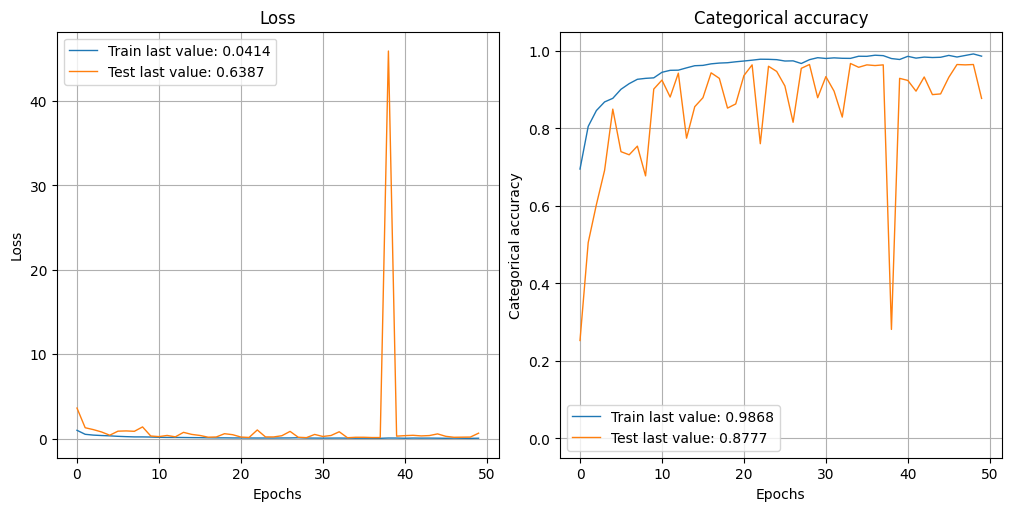

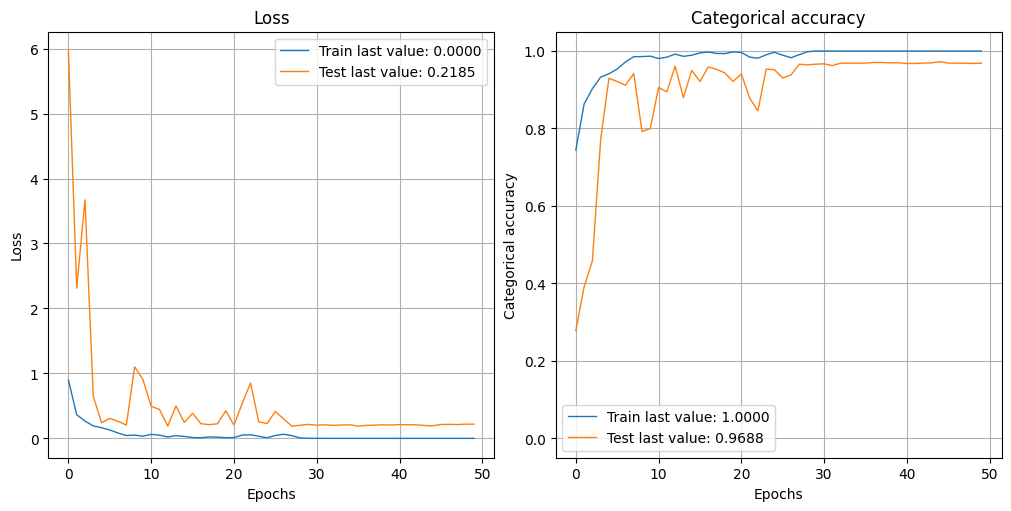

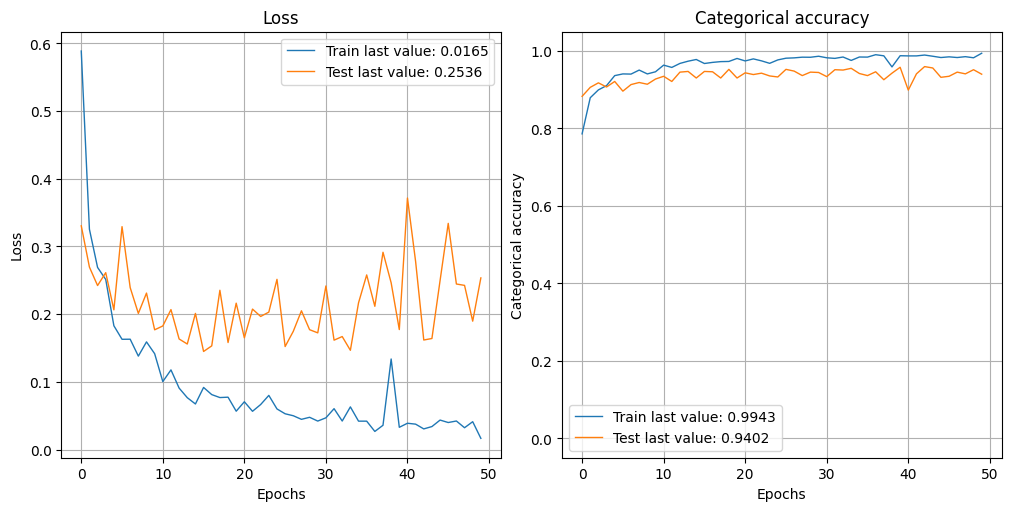

In [32]:
for model in histories:
    # Plot the model training history
    history = histories[model]
    plot_history(history)

# Evaluamos los modelos

In [33]:
print('Evaluación del modelo 1:')
test_model = tf.keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

print('\n')

print('Evaluación del modelo 2:')
test_model = tf.keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

print('\n')

print('Evaluación del modelo 3:')
test_model = tf.keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test3)
print(f"Test accuracy: {test_acc:.3f}")

Evaluación del modelo 1:
41/41 [==============================] - 14s 348ms/step - loss: 0.0718 - categorical_accuracy: 0.9741
Test accuracy: 0.974


Evaluación del modelo 2:
41/41 [==============================] - 5s 108ms/step - loss: 0.1152 - categorical_accuracy: 0.9748
Test accuracy: 0.975


Evaluación del modelo 3:
41/41 [==============================] - 12s 279ms/step - loss: 0.1279 - categorical_accuracy: 0.9565
Test accuracy: 0.957


# Conclusiones finales

Para concluir, vamos a tratar algunos aspectos importantes sobre la libreta realizada. 

* Alguno de los puntos más importante es la realización de técnicas de aumento de datos y de regularización para evitar el sobreajuste, lo cual se ha realizado tanto en el primer como en el tercer modelo y se ha podido comprobar como cuando, por ejemplo, cuando terminamos de entrenar los modelos, si nos fijamos en la gráfica de `categorical accuracy` vemos como el modelo sobreajusta. 

* También hemos querido realizar un modelo con Transfer Learning como alternativa a la red neuronal convolucional realizada en el primer modelo. Ambas tienen una evaluación final, aunque el primer modelo es ligeramente mejor.

* Cabe destacar que hemos dividido el train en validación y entrenamiento, algo que, a priori parece obvio, pero hemos podido comprobar que en libretas y proyectos que tratan bases de datos con imágenes y ejecutan redes neuronales utilizan el conjunto de prueba como si fuera el conjunto de validación.

* También hemos querido almacenar los modelos en un diccionario para que, a la hora de entrenarlos y obtener sus correspondientes gráficas, podamos ver las diferencias entre un modelo u otro. 